In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv(r'./data/predict_calorie_expenditure/train.csv')

In [19]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [7]:
df.drop(columns=['id']).describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


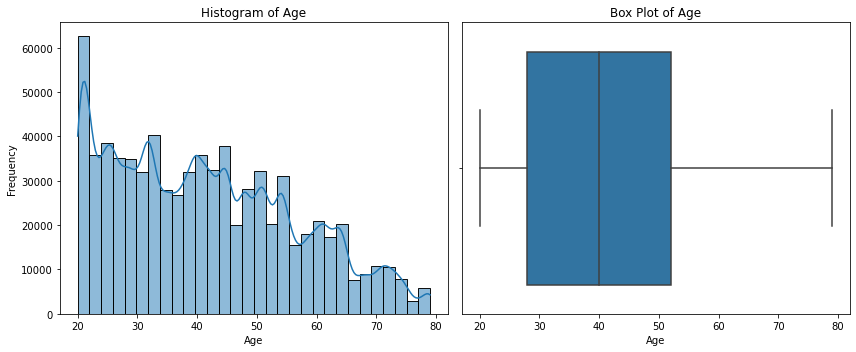


Statistics for Age:
Skewness: 0.44
Number of Missing Values: 0


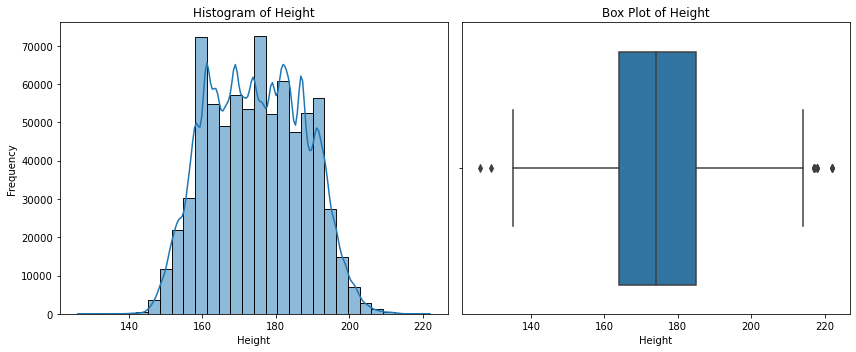


Statistics for Height:
Skewness: 0.05
Number of Missing Values: 0


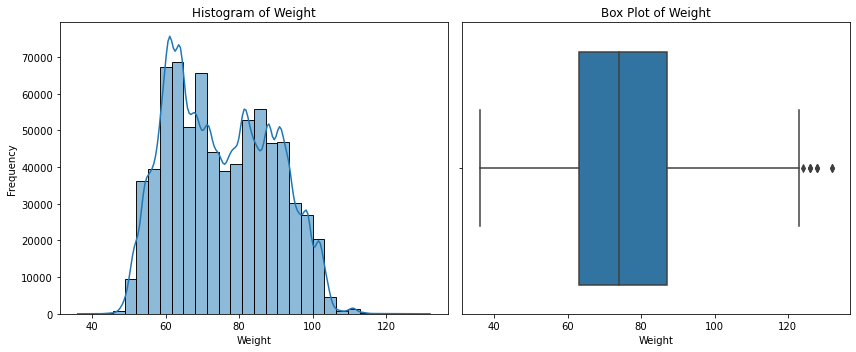


Statistics for Weight:
Skewness: 0.21
Number of Missing Values: 0


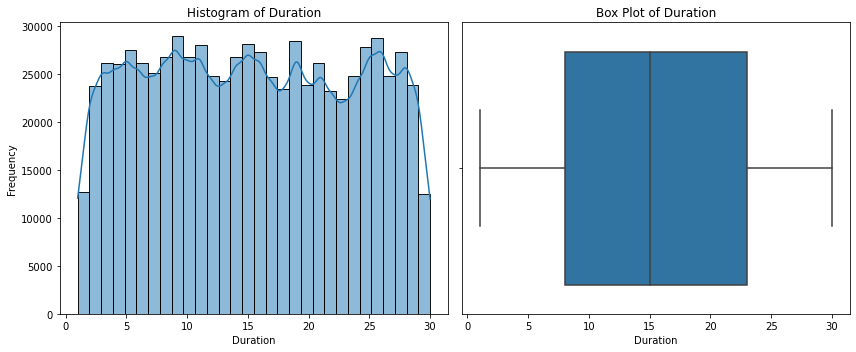


Statistics for Duration:
Skewness: 0.03
Number of Missing Values: 0


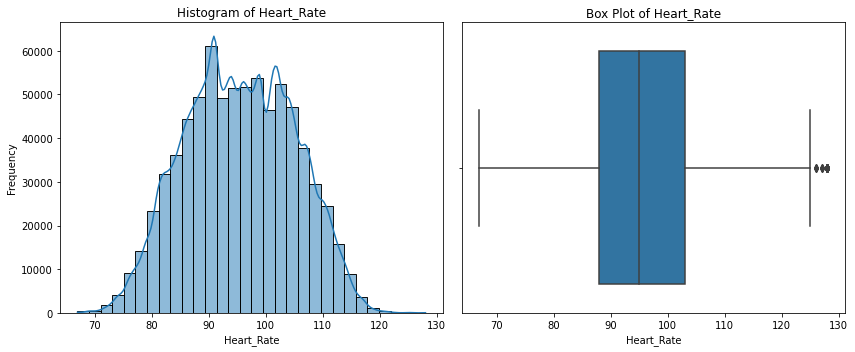


Statistics for Heart_Rate:
Skewness: -0.01
Number of Missing Values: 0


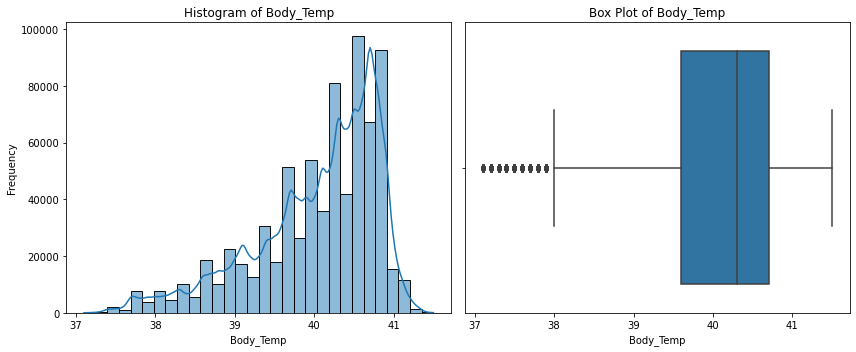


Statistics for Body_Temp:
Skewness: -1.02
Number of Missing Values: 0


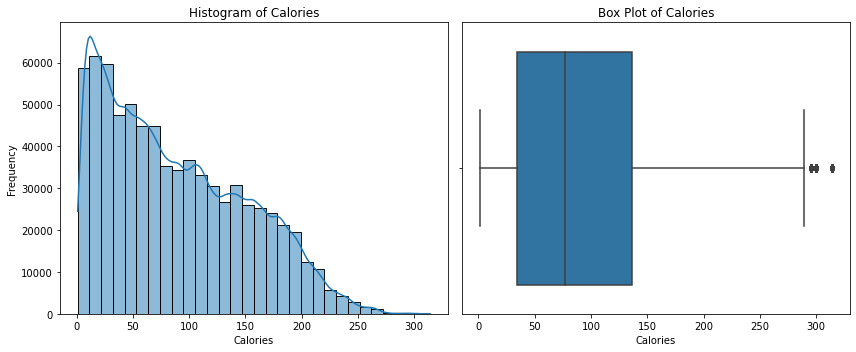


Statistics for Calories:
Skewness: 0.54
Number of Missing Values: 0


In [11]:
numerical_features = [
    "Age",
    "Height",
    "Weight",
    "Duration",
    "Heart_Rate",
    "Body_Temp",
    "Calories"
    
]

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

    print(f"\nStatistics for {feature}:")
    print(f"Skewness: {df[feature].skew():.2f}")
    print(f"Number of Missing Values: {df[feature].isnull().sum()}")

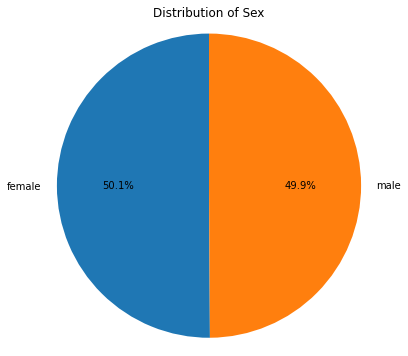

Number of Unique Calories: 277
Missing Values in Calories: 0


In [ ]:
sex_counts = df["Sex"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sex")
plt.axis("equal")
plt.show()

print(f"Number of Unique {feature}: {df[feature].nunique()}")
print(f"Missing Values in {feature}: {df[feature].isnull().sum()}")

In [30]:
print(columns)
df.loc[:,'Heart_Rate']

['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']


0         101.0
1          85.0
2          84.0
3         105.0
4         102.0
          ...  
749995    114.0
749996     92.0
749997    113.0
749998    102.0
749999     97.0
Name: Heart_Rate, Length: 750000, dtype: float64

In [40]:
numerical_columns

['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [53]:
numerical_columns = df.drop(columns=['id','Calories','Sex']).columns.to_list()

cleaned_df = df.drop(columns=['id']).copy()
for col in numerical_columns:
    print(col)
    Q1 = df.loc[:, col].quantile(0.25)
    Q3 = df.loc[:, col].quantile(0.75)
    IQR = Q3 - Q1
    upperBoundary = df.loc[:, col].median() + 1.5 * IQR
    lowerBoundary = df.loc[:, col].median() - 1.5 * IQR
    cleaned_df = cleaned_df.loc[(df.loc[:, col] <= upperBoundary) & (df.loc[:, col] >= lowerBoundary)]

cleaned_df.Sex = cleaned_df.Sex.map({'male':0,
                    'female':1})
cleaned_df

Age
Height
Weight
Duration
Heart_Rate
Body_Temp


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,64,163.0,60.0,8.0,85.0,39.7,34.0
2,1,51,161.0,64.0,7.0,84.0,39.8,29.0
3,0,20,192.0,90.0,25.0,105.0,40.7,140.0
4,1,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,0,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,1,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,0,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,0,45,182.0,91.0,17.0,102.0,40.3,109.0


In [ ]:
for feature in numerical_columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_df[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cleaned_df[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

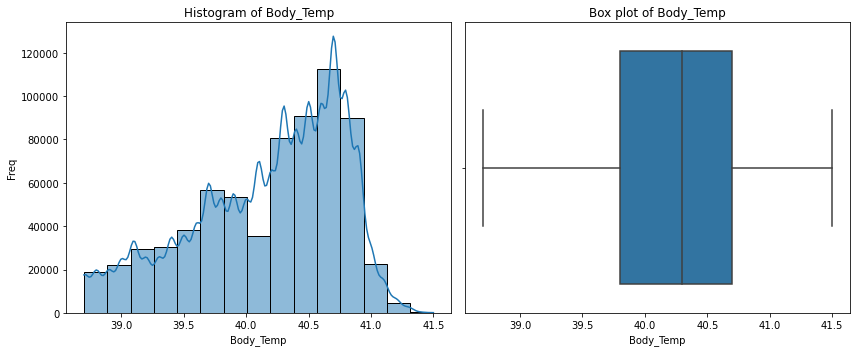

In [59]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(cleaned_df.Body_Temp, kde=True, bins=15)
plt.xlabel('Body_Temp')
plt.ylabel('Freq')
plt.title("Histogram of Body_Temp")

plt.subplot(1, 2, 2)
sns.boxplot(x = cleaned_df.Body_Temp)
plt.title("Box plot of Body_Temp")

plt.tight_layout()
plt.show()

# 建立模型
---

In [60]:
cleaned_df.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')

In [66]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
from tqdm import tqdm  # Import tqdm for progress tracking

# 選取特徵與輸出
X = cleaned_df.drop(columns=['Calories'])
y = cleaned_df.Calories

# 建立交叉驗證器
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 預留紀錄
oof_preds = np.zeros(len(X))  # Out-Of-Fold 預測分數
fold_scores = []              # 記錄每折的AUC

# 開始K折訓練
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 建立模型
    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Regression task
        colsample_bytree=0.3,          # Subsample ratio of columns
        learning_rate=0.1,             # Step size at each iteration
        max_depth=5,                   # Maximum depth of a tree
        alpha=10,                      # L2 regularization term
        n_estimators=1000,             # Number of trees
        random_state=42,
        verbose=200  # Set verbose to get more detailed output
    )

    # 訓練
    model.fit(X_train, y_train)

    # 預測
    val_preds = model.predict(X_val)
    
    # Predict OOF and test
    oof_preds[val_idx] = model.predict(X_val)

    rmse = np.sqrt(np.mean((y_val - oof_preds[val_idx])**2))
    print(f"Fold {fold} RMSE: {rmse:.4f}")

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\luke\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [21:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 0 RMSE: 3.9680


C:\Users\luke\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [21:57:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 RMSE: 4.0084


C:\Users\luke\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [21:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 RMSE: 4.0288


C:\Users\luke\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [21:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 RMSE: 3.9753


C:\Users\luke\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [21:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 RMSE: 3.9415


In [72]:
df_test = pd.read_csv(r'./data\predict_calorie_expenditure/test.csv')
X_test = df_test.drop(columns=['id']).copy()
X_test.Sex = X_test.Sex.map({'male':0,
                         'female':1})
y_test = model.predict(X_test)

In [82]:
output = pd.DataFrame(y_test,columns=['Calories'])
filter = output.Calories < 0
output.loc[filter]

,Calories
429,-2.098130
636,-0.730582
912,-0.160341
1430,-2.691804
2134,-3.148902
...,...
248476,-5.206288
248775,-1.285136
249665,-5.648099
249887,-0.994087


In [77]:
df_sub = pd.read_csv(r'./data\predict_calorie_expenditure/sample_submission.csv')
df_sub.Calories = y_test
df_sub.to_csv(r'./data\predict_calorie_expenditure/submission.csv',index=None)